# Classificador de tênis (Nike vs Adidas)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## Carregamento de dados dos datasets.

In [2]:
def datasetLoader(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    val_dir = os.path.join(data_dir, "Validation")

    train_data = ImageFolder(root=train_dir, transform=transform)
    test_data = ImageFolder(root=test_dir, transform=transform)
    val_data = ImageFolder(root=val_dir, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

In [3]:
data_dir = "Dataset"
train_loader, test_loader, val_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(train_loader.dataset.classes)
print(device)

cuda:0


In [4]:
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")
print(f"Número de amostras de validação: {len(val_loader.dataset)}")
print("Classes no conjunto de treinamento:")
print(train_loader.dataset.classes)

Número de amostras de treinamento: 459
Número de amostras de teste: 50
Número de amostras de validação: 55
Classes no conjunto de treinamento:
['adidas', 'nike']


In [5]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = nn.Linear(2048, num_classes)
resnet = resnet.to(device)

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Métodos 

### Matriz de confusão

In [6]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

### Acurácia

In [7]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

### F1 score

In [8]:
from sklearn.metrics import f1_score

def calculate_f1_score(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return f1_score(true_labels, predicted_labels, average='macro')

### ROC AUC métrica

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_roc_auc_score(model, loader, n_classes):
    model.eval()
    true_labels = []
    predicted_probs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())
    true_labels = label_binarize(true_labels, classes=[i for i in range(n_classes)])
    return roc_auc_score(true_labels, predicted_probs, multi_class='ovr')

### Validação

In [10]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
    return val_loss/len(loader)

### Regularização

l1_lambda e l2 lambda são os pesos/intensidade que a regularização aplicará no modelo.

In [11]:
def l1_regularization(model, l1_lambda, device):
    l1_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L1 dos parâmetros e somando-as
        l1_reg += torch.norm(param, 1)
    # Multiplicando pela lambda para obter o termo de regularização L1
    return l1_lambda * l1_reg

In [12]:
def l2_regularization(model, l2_lambda, device):
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L2 dos parâmetros e somando suas raízes quadradas
        l2_reg += torch.norm(param, 2) ** 2
    # Multiplicando pela lambda e raiz quadrada para obter o termo de regularização L2
    return l2_lambda * torch.sqrt(l2_reg)

### Treinamento

In [13]:
import matplotlib.pyplot as plt

def train(model, trainloader, testloader, optimizer, criterion, epochs, l1_lambda, l2_lambda):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            l1_reg = l1_regularization(model, l1_lambda, device)
            loss += l1_reg
            l2_reg = l2_regularization(model, l2_lambda, device)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = validation(model, testloader, criterion)
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1} | Train Loss: {train_losses[-1]} | Val Loss: {val_loss}')

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

## Registro de evoluções nos modelos
- 1º modelo era treinado com apenas 3 épocas e com learning rate de 0,001. **Acurácia de 70%**.
- 2º modelo subimos o número de épocas para 30 (número baseado nos modelos analisados da referência 1) e ajustamos o learning rate para 0,0001. **Acurácia de 88%**.
- 3º modelo inserimos regularização L1 e L2 com peso da regularização de 0,01. **Acurácia caiu para 76%**
- 4º modelo ajustamos os parâmetros de pesos da regularização L1 e L2 para de 0,0001. **Acurácia de 90%**

Referências:  
1 - https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset/code

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
l1_lambda = 0.0001
l2_lambda = 0.0001
epochs = 30

## Treinamento

  8%|▊         | 3/39 [00:01<00:18,  1.90it/s]c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 39/39 [00:13<00:00,  2.87it/s]


Epoch: 1 | Train Loss: 27.238721603002304 | Val Loss: 0.8823732540418859


100%|██████████| 39/39 [00:13<00:00,  2.84it/s]


Epoch: 2 | Train Loss: 25.76867157373673 | Val Loss: 0.5161948818713427


100%|██████████| 39/39 [00:12<00:00,  3.08it/s]


Epoch: 3 | Train Loss: 24.436849007239708 | Val Loss: 0.40538406861014664


100%|██████████| 39/39 [00:12<00:00,  3.09it/s]


Epoch: 4 | Train Loss: 23.09393149155837 | Val Loss: 0.16411735340952874


100%|██████████| 39/39 [00:12<00:00,  3.09it/s]


Epoch: 5 | Train Loss: 21.83862519875551 | Val Loss: 0.16077448278665543


100%|██████████| 39/39 [00:12<00:00,  3.09it/s]


Epoch: 6 | Train Loss: 20.600041560637646 | Val Loss: 0.2749565980397165


100%|██████████| 39/39 [00:12<00:00,  3.08it/s]


Epoch: 7 | Train Loss: 19.481047116793118 | Val Loss: 0.11523049548268319


100%|██████████| 39/39 [00:12<00:00,  3.09it/s]


Epoch: 8 | Train Loss: 18.449415793785683 | Val Loss: 1.1995981675514487


100%|██████████| 39/39 [00:12<00:00,  3.08it/s]


Epoch: 9 | Train Loss: 17.62382575793144 | Val Loss: 0.24748776627720873


100%|██████████| 39/39 [00:12<00:00,  3.03it/s]


Epoch: 10 | Train Loss: 16.761078174297626 | Val Loss: 0.851918647732964


100%|██████████| 39/39 [00:12<00:00,  3.01it/s]


Epoch: 11 | Train Loss: 15.973901626391289 | Val Loss: 0.6080028116703033


100%|██████████| 39/39 [00:12<00:00,  3.06it/s]


Epoch: 12 | Train Loss: 15.371279863210825 | Val Loss: 0.24118586406111717


100%|██████████| 39/39 [00:12<00:00,  3.06it/s]


Epoch: 13 | Train Loss: 14.754053213657476 | Val Loss: 0.27141191624104977


100%|██████████| 39/39 [00:12<00:00,  3.05it/s]


Epoch: 14 | Train Loss: 14.038412045209835 | Val Loss: 0.14739956185221673


100%|██████████| 39/39 [00:12<00:00,  3.05it/s]


Epoch: 15 | Train Loss: 13.291951448489458 | Val Loss: 0.13296259490307422


100%|██████████| 39/39 [00:12<00:00,  3.05it/s]


Epoch: 16 | Train Loss: 12.641897666148651 | Val Loss: 0.10759555245749652


100%|██████████| 39/39 [00:13<00:00,  3.00it/s]


Epoch: 17 | Train Loss: 12.188293946095001 | Val Loss: 0.10308231450617314


100%|██████████| 39/39 [00:12<00:00,  3.03it/s]


Epoch: 18 | Train Loss: 11.824819149115147 | Val Loss: 0.411301964498125


100%|██████████| 39/39 [00:12<00:00,  3.04it/s]


Epoch: 19 | Train Loss: 11.28205548799955 | Val Loss: 0.10823983699083328


100%|██████████| 39/39 [00:12<00:00,  3.05it/s]


Epoch: 20 | Train Loss: 10.93045557462252 | Val Loss: 0.3680603034794331


100%|██████████| 39/39 [00:12<00:00,  3.05it/s]


Epoch: 21 | Train Loss: 10.53508105644813 | Val Loss: 0.39917198205366733


100%|██████████| 39/39 [00:12<00:00,  3.02it/s]


Epoch: 22 | Train Loss: 10.158062470264923 | Val Loss: 0.07393552288413048


100%|██████████| 39/39 [00:13<00:00,  3.00it/s]


Epoch: 23 | Train Loss: 9.689238817263872 | Val Loss: 0.12080308776348829


100%|██████████| 39/39 [00:12<00:00,  3.03it/s]


Epoch: 24 | Train Loss: 9.476024554325985 | Val Loss: 0.11202089905273169


100%|██████████| 39/39 [00:12<00:00,  3.00it/s]


Epoch: 25 | Train Loss: 9.435802973233736 | Val Loss: 0.13395912945270538


100%|██████████| 39/39 [00:12<00:00,  3.02it/s]


Epoch: 26 | Train Loss: 8.85891268803523 | Val Loss: 0.39508521914249284


100%|██████████| 39/39 [00:12<00:00,  3.02it/s]


Epoch: 27 | Train Loss: 8.5233550683046 | Val Loss: 0.106976263737306


100%|██████████| 39/39 [00:12<00:00,  3.02it/s]


Epoch: 28 | Train Loss: 8.17194179388193 | Val Loss: 2.1992090395651758


100%|██████████| 39/39 [00:12<00:00,  3.02it/s]


Epoch: 29 | Train Loss: 8.446500876010992 | Val Loss: 0.49362796992063523


100%|██████████| 39/39 [00:13<00:00,  3.00it/s]


Epoch: 30 | Train Loss: 7.9511350974058495 | Val Loss: 0.1536556485807523


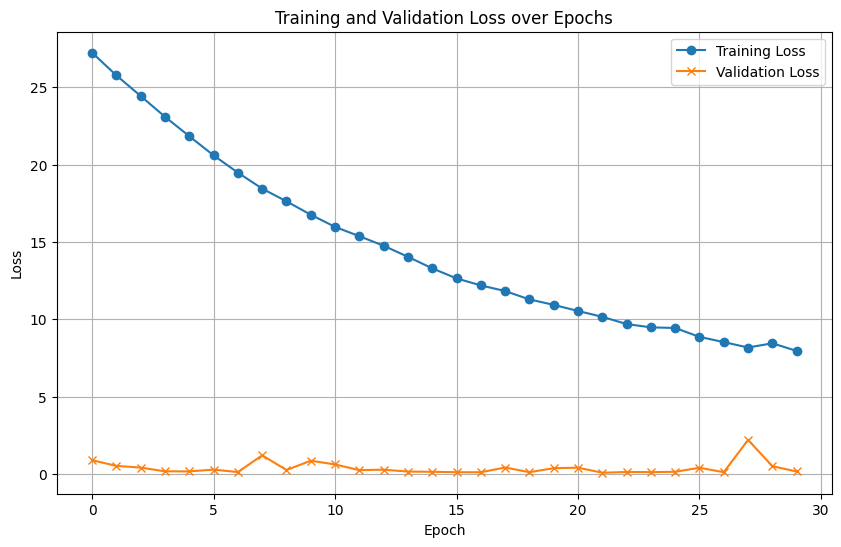

In [15]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs=epochs, l1_lambda=l1_lambda, l2_lambda=l2_lambda)

## Métricas de avaliação

### Acurácia do modelo em validação

A rede atinge: 92% de acurácia
A rede atinge: 91.99% de recall
A rede atinge: 99.52% de ROC AUC Score


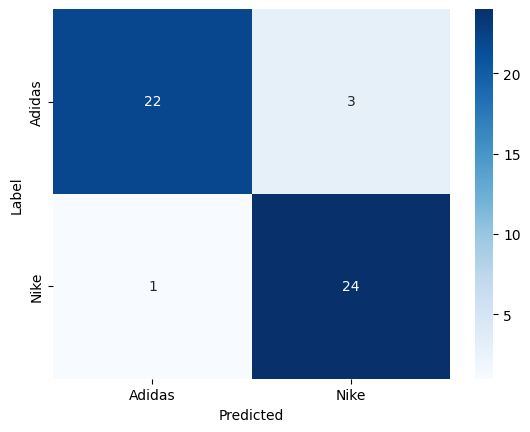

In [16]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, test_loader)*100,2)}% de recall')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, test_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, test_loader)

### Acurácia do modelo em treinamento

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


A rede atinge: 99% de acurácia
A rede atinge: 99.78% de recall


c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


A rede atinge: 100.0% de ROC AUC Score


c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


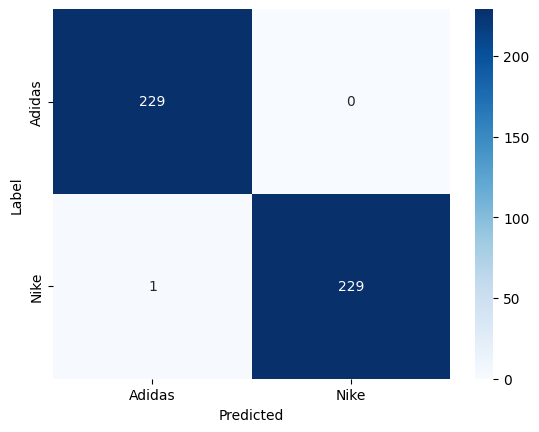

In [17]:
print(f'A rede atinge: {accuracy(resnet, train_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, train_loader)*100,2)}% de recall')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, train_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, train_loader)

In [18]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Usabilidade de webcam

In [19]:
import cv2

cap = cv2.VideoCapture(0)

img_counter = 0

while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('e'):
            img_name = "WebcamImages/print_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

cap.release()
cv2.destroyAllWindows()

### Predição

In [20]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Adidas' if result == 0 else 'Nike'

### Predição das classes da webcam

In [21]:
from PIL import Image
for filename in os.listdir('WebcamImages'):
    if filename.endswith(".png"):
        x = Image.open('WebcamImages/' + filename).convert('RGB')
        x = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(x)
        print(f'Image: {filename} | Resnet Prediction: {predict(resnet, x)}')

Image: print_0.png | Resnet Prediction: Nike
Image: print_1.png | Resnet Prediction: Nike
